<a href="https://colab.research.google.com/github/Prakruthir12/Potato-Disease-Classification/blob/main/Potato_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Potato Disease Classification

Dataset : https://www.kaggle.com/arjuntejaswi/plant-village

**Import all the Dependencies**

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/PlantVillage.zip

Archive:  /content/drive/MyDrive/PlantVillage.zip
   creating: PlantVillage/Potato___Early_blight/
  inflating: PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: PlantVillage/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: PlantVillage/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: PlantVillage/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: PlantVillage/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: PlantVillage/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: PlantVillage/Potato___Early_blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: PlantVillage/Potato___Early_blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_Early.B 8546.JPG  
  inflating: PlantVillage/Pot

**Set all the Constants**

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

**Import data into tensorflow dataset object**

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 2 1 2 0]


**Visualize some of the images from our dataset**

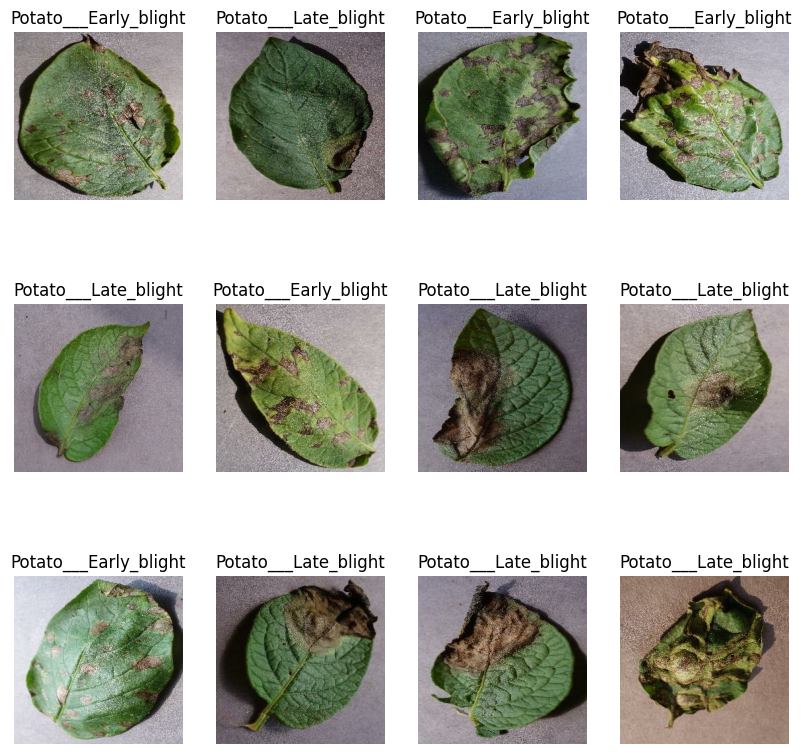

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

80% ==> training

20% ==> 10% validation, 10% test

###Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

1.Training: Dataset to be used while training

2.Validation: Dataset to be tested against while training

3.Test: Dataset to be tested against after we trained a model

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

**Cache, Shuffle, and Prefetch the Dataset**

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model
**Creating a Layer for Resizing and Normalization**

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

**Applying Data Augmentation to Train Dataset**

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
**We use a CNN coupled with a Softmax activation in the output layer.**

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

### Compiling the Model
**We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric**

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 [==============================] - 318s 6s/step - loss: 0.9019 - accuracy: 0.4722 - val_loss: 0.8885 - val_accuracy: 0.7031
Epoch 2/30
54/54 [==============================] - 299s 6s/step - loss: 0.7616 - accuracy: 0.6331 - val_loss: 0.5704 - val_accuracy: 0.7760
Epoch 3/30
54/54 [==============================] - 281s 5s/step - loss: 0.5739 - accuracy: 0.7373 - val_loss: 0.5193 - val_accuracy: 0.7969
Epoch 4/30
54/54 [==============================] - 280s 5s/step - loss: 0.4782 - accuracy: 0.7824 - val_loss: 0.4098 - val_accuracy: 0.8385
Epoch 5/30
54/54 [==============================] - 284s 5s/step - loss: 0.3510 - accuracy: 0.8600 - val_loss: 0.2814 - val_accuracy: 0.8958
Epoch 6/30
54/54 [==============================] - 280s 5s/step - loss: 0.2670 - accuracy: 0.8987 - val_loss: 0.4509 - val_accuracy: 0.8542
Epoch 7/30
54/54 [==============================] - 285s 5s/step - loss: 0.2149 - accuracy: 0.9219 - val_loss: 0.4343 - val_accuracy: 0.8750
Epoch 8/30
54

In [39]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 9s 1s/step - loss: 0.2507 - accuracy: 0.9062


In [ ]:
scores

**Plotting the Accuracy and Loss Curves**

In [ ]:
history

In [44]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [45]:
type(history.history['loss'])

list

In [46]:
len(history.history['loss'])

30

In [42]:
history.history['loss'][:5] #loss for first 5 epochs

[0.9018975496292114,
 0.7615842223167419,
 0.5739306807518005,
 0.4782075583934784,
 0.35100847482681274]

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

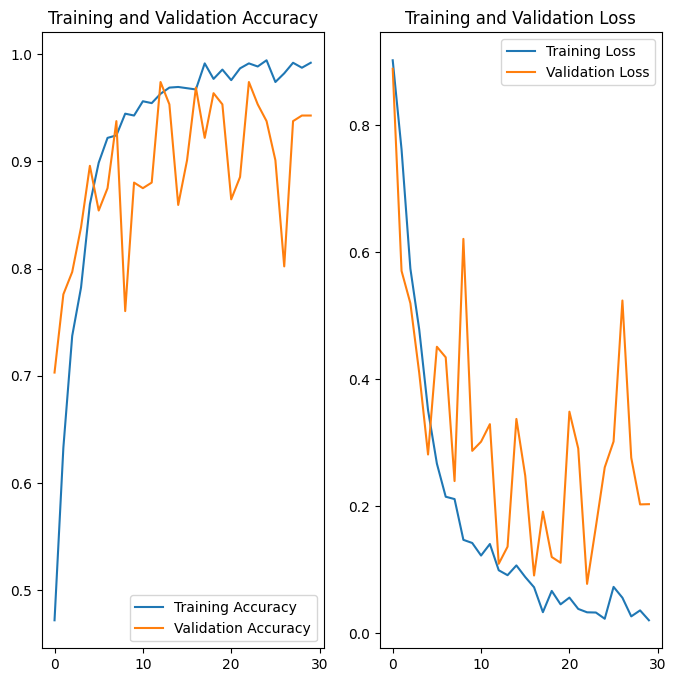

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Run prediction on a sample image**

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Early_blight


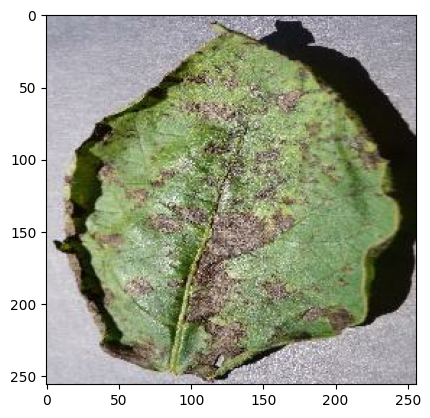

In [49]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [50]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) #create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])))
  return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 55ms/step


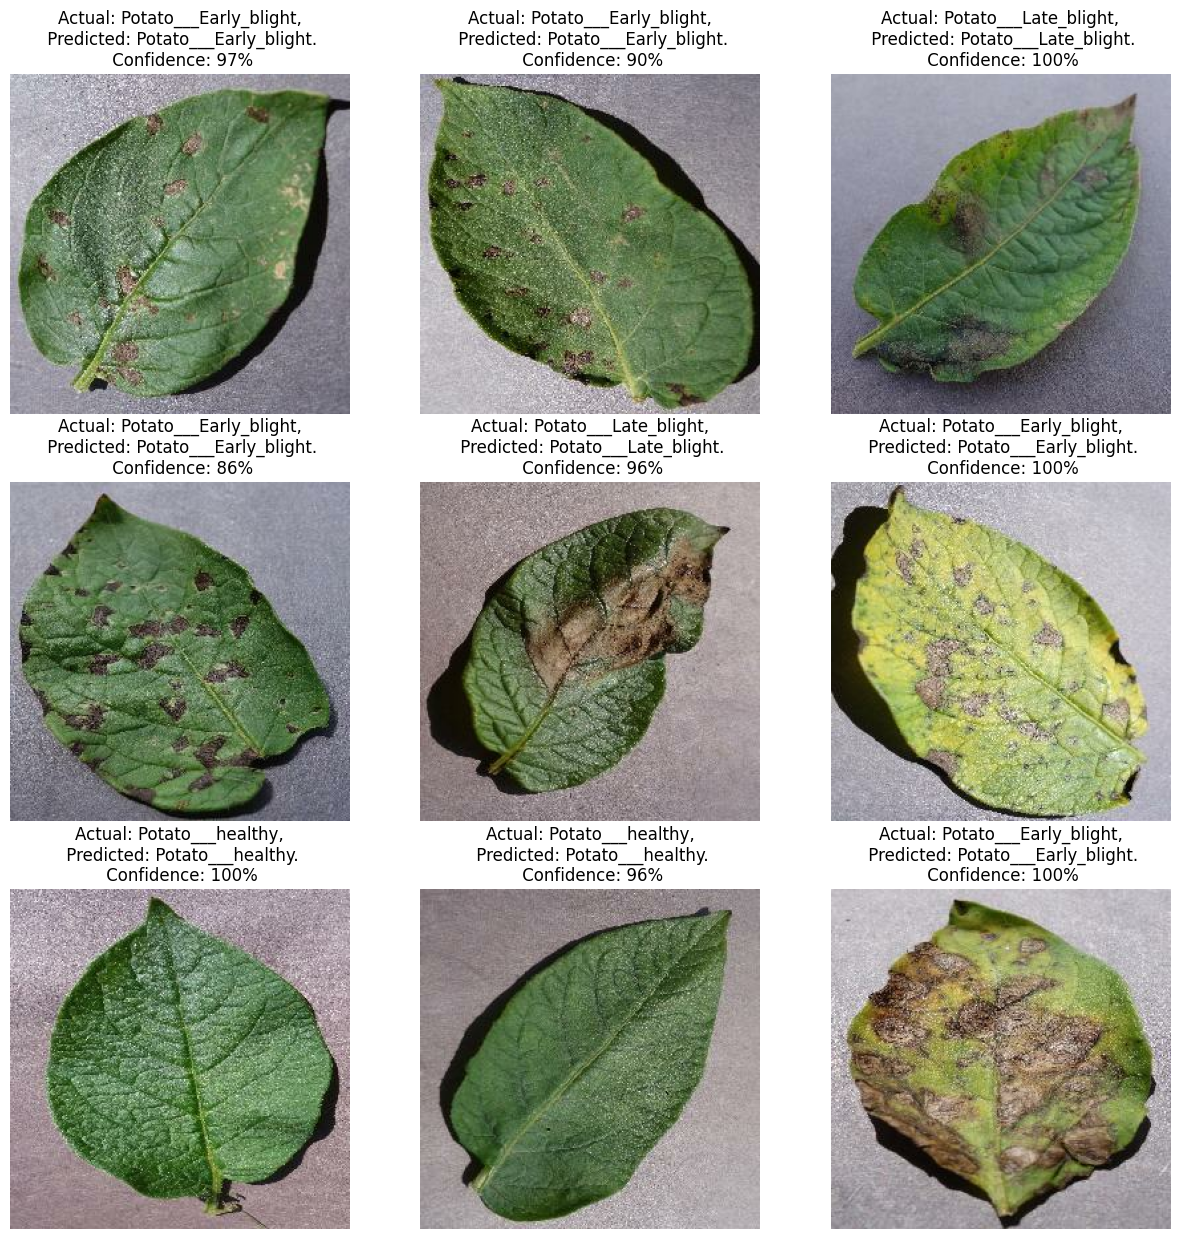

In [51]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")


### Saving the Model
**We append the model to the list of models as a new version**

In [34]:
!mkdir models

In [35]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

In [41]:
!zip -r /content/models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/1/ (stored 0%)
  adding: content/models/1/keras_metadata.pb (deflated 94%)
  adding: content/models/1/saved_model.pb (deflated 90%)
  adding: content/models/1/fingerprint.pb (stored 0%)
  adding: content/models/1/assets/ (stored 0%)
  adding: content/models/1/variables/ (stored 0%)
  adding: content/models/1/variables/variables.index (deflated 68%)
  adding: content/models/1/variables/variables.data-00000-of-00001 (deflated 7%)


In [36]:
model.save("potatoes.h5")

In [37]:
!ls
from google.colab import files
files.download('potatoes.h5')

drive  models  PlantVillage  potatoes.h5  sample_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>